In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Input, Model, Sequential
import keras
import time
#from keras.utils import np_utils
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import LSTM, RNN, Dense, Bidirectional, Input,Dropout,BatchNormalization,Flatten,\
                Activation, Conv1D, Concatenate, Reshape, Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,\
        precision_score, recall_score, make_scorer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Masking, GlobalAveragePooling1D
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import collections
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Embedding
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import AdamW, Adam
import random
from keras import backend as K
import concurrent.futures
from threading import Lock, Thread
import copy
from itertools import combinations
from tqdm import tqdm
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Trexquant/')

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Trexquant/words_250000_train.txt", header = None).rename(columns = {0:'word'}).dropna().reset_index(drop=True)

In [5]:
data.shape

(227299, 1)

In [6]:
all(data.word.apply(lambda x: x.lower()) == data.word)

True

In [7]:
sorted(set("".join(data.word.to_list())))

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [8]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
data_train, data_dev = train_test_split(data_train, test_size=2/7, random_state=42)

In [9]:
data_train.shape, data_dev.shape, data_test.shape

((129885, 1), (51954, 1), (45460, 1))

In [10]:
np.mean([len(i) for i in data_train.word.values]), np.mean([len(i) for i in data_dev.word.values]), np.mean([len(i) for i in data_test.word.values])

(9.343388382030257, 9.35849020287177, 9.348108227012759)

In [11]:
print('Training with {} words'.format(data_train.shape[0]))
print('Validating with {} words'.format(data_dev.shape[0]))
print('Testing with {} words'.format(data_test.shape[0]))

MAX_NUM_INPUTS = max([len(i) for i in data.word.values])
print('Max word length: {}'.format(MAX_NUM_INPUTS))

Training with 129885 words
Validating with 51954 words
Testing with 45460 words
Max word length: 29


In [12]:
FULL_DICTIONARY = data_train.word.to_list()
len(FULL_DICTIONARY)

129885

In [13]:
len(sorted(set("".join(FULL_DICTIONARY)))) == 26

True

In [14]:
def build_ngram_models():
  # create a nested dictionary that stores the occurrences of letter sequences ranging from 1 to 5 characters in length.
  # the nested dictionary will have an additional level to account for the length of each word in unigrams and bigrams.
  # for the unigram level, consider only the unique letters within each word.

  unigram = collections.defaultdict(int)
  bigram = collections.defaultdict(int)
  trigram = collections.defaultdict(int)
  fourgram = collections.defaultdict(int)
  fivegram = collections.defaultdict(int)

  # iterating through each word in the dictionary
  # count the occurrences of letter sequences in words from the dictionary and update the n-gram models accordingly.
  for word in FULL_DICTIONARY:
      # check each letter in the dictionary and update the ngram
      for i in range(len(word) - 4):
          # We exclude the last four letters of the word because it is searching for patterns of
          # four consecutive letters with a blank in the fifth position. Since the last four letters
          # cannot form such a pattern, there is no need to check them, resulting in improved efficiency
          # and focusing on the relevant parts of the word.

          bigram[(len(word), word[i], word[i+1])] += 1
          trigram[(word[i], word[i+1], word[i+2])] += 1
          fourgram[(word[i], word[i+1], word[i+2], word[i+3])] += 1
          fivegram[(word[i], word[i+1], word[i+2], word[i+3], word[i+4])] += 1

      i = len(word) - 4

      # fill rest of the ngrams for words very small words and complete coverage
      if len(word) == 2:
          bigram[(len(word),word[0],word[1])] += 1
      elif len(word) == 3:
          bigram[(len(word),word[0],word[1])] += 1
          bigram[(len(word),word[1],word[2])] += 1
          trigram[(word[0],word[1],word[2])] += 1
      # fill out rest of the fourgrams
      elif len(word) >= 4:
          bigram[(len(word),word[i],word[i+1])] += 1
          bigram[(len(word),word[i+1],word[i+2])] += 1
          bigram[(len(word),word[i+2],word[i+3])] += 1
          trigram[(word[i],word[i+1],word[i+2])] += 1
          trigram[(word[i+1],word[i+2],word[i+3])] += 1
          fourgram[(word[i],word[i+1],word[i+2],word[i+3])] += 1

      # fill out unigrams
      for letter in set(word):
          unigram[(len(word),letter)] += 1

  return unigram, bigram, trigram, fourgram, fivegram

In [15]:
UNIGRAM, BIGRAM, TRIGRAM, FOURGRAM, FIVEGRAM = build_ngram_models()

In [ ]:
UNIGRAM_MINUS, BIGRAM_MINUS, TRIGRAM_MINUS, FOURGRAM_MINUS, FIVEGRAM_MINUS = {}, {}, {}, {}, {}

In [ ]:
BAD_WORDS = {}

Verify there is no Thread competition: https://superfastpython.com/thread-safe-dictionary-in-python/

In [41]:
# SuperFastPython.com
# example of thread-safe adding items to a shared dict
from threading import Thread

# create a dictionary with 1 million items
shared_dict = dict()
print(f'Dict has {len(shared_dict)} items')

# add a range of values to the dictionary
def add_items(start_value, num_values):
    # enumerate block of values
    for i in range(start_value, start_value+num_values):
        # add to the dict
        shared_dict[i] = i

# configure threads
threads = list()
for i in range(0, 1000000, 1000):
    thread = Thread(target=add_items, args=(i, 1000))
    threads.append(thread)
print(f'Created {len(threads)} threads')
t = time.time()
# start threads
for thread in threads:
    thread.start()
# wait for threads to finish
for thread in threads:
    thread.join()
print(time.time()-t)
print(f'Dict has {len(shared_dict)} items')

Dict has 0 items
Created 1000 threads
0.22268891334533691
Dict has 1000000 items


In [18]:
def reoptimize_ngrams(letters):

  letters = tuple(sorted(letters))
  new_letter = letters[-1]

  if len(letters) == 1:
      new_bad_words = set([word for word in FULL_DICTIONARY if set(word).intersection(set({new_letter}))])

      unigram = copy.copy(UNIGRAM)
      bigram = copy.copy(BIGRAM)
      trigram = copy.copy(TRIGRAM)
      fourgram = copy.copy(FOURGRAM)
      fivegram = copy.copy(FIVEGRAM)

      BAD_WORDS[letters] = new_bad_words

  else:
      old_letters = letters[:-1]

      bad_words = set([word for word in FULL_DICTIONARY if set(word).intersection(set({new_letter}))])
      new_bad_words = bad_words - BAD_WORDS[old_letters]

      unigram = copy.copy(UNIGRAM_MINUS[old_letters])
      bigram = copy.copy(BIGRAM_MINUS[old_letters])
      trigram = copy.copy(TRIGRAM_MINUS[old_letters])
      fourgram = copy.copy(FOURGRAM_MINUS[old_letters])
      fivegram = copy.copy(FIVEGRAM_MINUS[old_letters])

      BAD_WORDS[letters] = BAD_WORDS[old_letters].union(new_bad_words)

  # iterating through each word in the dictionary
  # count the occurrences of letter sequences in words from the dictionary and update the n-gram models accordingly.
  for word in new_bad_words:
      # check each letter in the dictionary and update the ngram
      for i in range(len(word) - 4):
          # We exclude the last four letters of the word because it is searching for patterns of
          # four consecutive letters with a blank in the fifth position. Since the last four letters
          # cannot form such a pattern, there is no need to check them, resulting in improved efficiency
          # and focusing on the relevant parts of the word.

          bigram[(len(word), word[i], word[i+1])] -= 1
          trigram[(word[i], word[i+1], word[i+2])] -= 1
          fourgram[(word[i], word[i+1], word[i+2], word[i+3])] -= 1
          fivegram[(word[i], word[i+1], word[i+2], word[i+3], word[i+4])] -= 1

      i = len(word) - 4

      # fill rest of the ngrams for words very small words and complete coverage
      if len(word) == 2:
          bigram[(len(word),word[0],word[1])] -= 1
      elif len(word) == 3:
          bigram[(len(word),word[0],word[1])] -= 1
          bigram[(len(word),word[1],word[2])] -= 1
          trigram[(word[0],word[1],word[2])] -= 1
      # fill out rest of the fourgrams
      elif len(word) >= 4:
          bigram[(len(word),word[i],word[i+1])] -= 1
          bigram[(len(word),word[i+1],word[i+2])] -= 1
          bigram[(len(word),word[i+2],word[i+3])] -= 1
          trigram[(word[i],word[i+1],word[i+2])] -= 1
          trigram[(word[i+1],word[i+2],word[i+3])] -= 1
          fourgram[(word[i],word[i+1],word[i+2],word[i+3])] -= 1

      # fill out unigrams
      for letter in set(word):
          unigram[(len(word),letter)] -= 1

  UNIGRAM_MINUS[letters] = unigram
  BIGRAM_MINUS[letters] = bigram
  TRIGRAM_MINUS[letters] = trigram
  FOURGRAM_MINUS[letters] = fourgram
  FIVEGRAM_MINUS[letters] = fivegram

In [19]:
def factorial(n):
  if n == 1:
    return 1
  else:
    return n*factorial(n-1)
def n_combinations(n):
  return int(factorial(26)/(factorial(n) * factorial(26-n)))

In [ ]:
for i in range(1,4): # at most 5 words dropped (6 lives). Let's precompute first 3
  n_tasks = n_combinations(i)
  with tqdm(total=n_tasks) as pbar:
    with concurrent.futures.ThreadPoolExecutor(max_workers=min(n_tasks//2, 200)) as executor:
        futures = [executor.submit(reoptimize_ngrams, set(c)) for c in combinations(sorted(set("".join(FULL_DICTIONARY))), i)]
        for future in concurrent.futures.as_completed(futures):
            pbar.update(1)

  0%|          | 0/14950 [00:00<?, ?it/s]

In [16]:
with open('/content/drive/MyDrive/Trexquant/unigrams.pkl', 'wb') as fp:
    pickle.dump(UNIGRAM, fp)
with open('/content/drive/MyDrive/Trexquant/bigrams.pkl', 'wb') as fp:
    pickle.dump(BIGRAM, fp)
with open('/content/drive/MyDrive/Trexquant/trigrams.pkl', 'wb') as fp:
    pickle.dump(TRIGRAM, fp)
with open('/content/drive/MyDrive/Trexquant/fourgrams.pkl', 'wb') as fp:
    pickle.dump(FOURGRAM, fp)
with open('/content/drive/MyDrive/Trexquant/fivegrams.pkl', 'wb') as fp:
    pickle.dump(FIVEGRAM, fp)

In [ ]:
with open('/content/drive/MyDrive/Trexquant/unigrams_minus.pkl', 'wb') as fp:
    pickle.dump(UNIGRAM_MINUS, fp)
with open('/content/drive/MyDrive/Trexquant/bigrams_minus.pkl', 'wb') as fp:
    pickle.dump(BIGRAM_MINUS, fp)
with open('/content/drive/MyDrive/Trexquant/trigrams_minus.pkl', 'wb') as fp:
    pickle.dump(TRIGRAM_MINUS, fp)
with open('/content/drive/MyDrive/Trexquant/fourgrams_minus.pkl', 'wb') as fp:
    pickle.dump(FOURGRAM_MINUS, fp)
with open('/content/drive/MyDrive/Trexquant/fivegrams_minus.pkl', 'wb') as fp:
    pickle.dump(FIVEGRAM_MINUS, fp)
with open('/content/drive/MyDrive/Trexquant/bad_words.pkl', 'wb') as fp:
    pickle.dump(BAD_WORDS, fp)

In [17]:
with open('/content/drive/MyDrive/Trexquant/unigrams.pkl', 'rb') as fp:
    UNIGRAM = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/bigrams.pkl', 'rb') as fp:
    BIGRAM = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/trigrams.pkl', 'rb') as fp:
    TRIGRAM = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/fourgrams.pkl', 'rb') as fp:
    FOURGRAM = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/fivegrams.pkl', 'rb') as fp:
    FIVEGRAM = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/unigrams_minus.pkl', 'rb') as fp:
    UNIGRAM_MINUS = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/bigrams_minus.pkl', 'rb') as fp:
    BIGRAM_MINUS = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/trigrams_minus.pkl', 'rb') as fp:
    TRIGRAM_MINUS = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/fourgrams_minus.pkl', 'rb') as fp:
    FOURGRAM_MINUS = pickle.load(fp)
with open('/content/drive/MyDrive/Trexquant/fivegrams_minus.pkl', 'rb') as fp:
    FIVEGRAM_MINUS = pickle.load(fp)

In [19]:
@tf.function(reduce_retracing=True)
def call_method(model, input, training = True):
  return model(input, training = training)

In [20]:
class HangmanPlayer:
    def __init__(self, word, model, full_dictionary, unigram, bigram, trigram, fourgram, fivegram, \
                                unigram_minus, bigram_minus, trigram_minus, fourgram_minus, fivegram_minus, lives=6):
        self.original_word = word
        self.full_word = [ord(i)-97 for i in word]
        self.letters_guessed = set([])
        self.guessed_letters = []
        self.letters_remaining = set(self.full_word)
        self.letters_remaining_count = collections.Counter(self.full_word)
        self.lives_left = lives
        self.obscured_words_seen = []
        self.letters_previously_guessed = []
        self.correct_responses = []
        self.z = model
        self.full_dictionary = full_dictionary
        self.letter_set = sorted(set("".join(self.full_dictionary)))
        self.unigram_probabilities = None
        self.bigram_probabilities = None
        self.trigram_probabilities = None
        self.fourgram_probabilities = None
        self.fivegram_probabilities = None
        self.unigram, self.bigram, self.trigram, self.fourgram, self.fivegram = unigram, bigram, trigram, fourgram, fivegram
        self.unigram_minus, self.bigram_minus, self.trigram_minus, self.fourgram_minus, self.fivegram_minus = \
                        unigram_minus, bigram_minus, trigram_minus, fourgram_minus, fivegram_minus
        self.encoded_stacked_ngrams_probs = []
        self.wrong_guesses_ngrams = ()



    def fivegram_probability(self, word):

      #given an input word in a clean format with no spaces and placeholders ('_') for unknown letters,
      #the process utilizes five-grams to determine the likelihood of a specific letter appearing in a five-letter sequence for a word of a given length.
      #the output provides the probabilities for each letter, which will be utilized in the subsequent stage.

      # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        for i in range(len(word) - 4):

            # case 1: "eg word:  abcd_ "
            if word[i] != '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] != '_' and word[i+4] == '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+2]
                anchor_letter4 = word[i+3]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram[(anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram[(anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4, letter)]
                            letter_count[j] += self.fivegram[(anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4, letter)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4, letter)]
                            letter_count[j] += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4, letter)]

            # case 2: "eg word: abc_e "
            elif word[i] != '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] == '_' and word[i+4] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+2]
                anchor_letter4 = word[i+4]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram[(anchor_letter1, anchor_letter2, anchor_letter3, letter, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram[(anchor_letter1, anchor_letter2, anchor_letter3, letter, anchor_letter4)]
                            letter_count[j] += self.fivegram[(anchor_letter1, anchor_letter2, anchor_letter3, letter, anchor_letter4)]

                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, letter, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, letter, anchor_letter4)]
                            letter_count[j] += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, letter, anchor_letter4)]

            # case 3: "eg word: ab_de "
            elif word[i] != '_' and word[i+1] != '_' and word[i+2] == '_' and word[i+3] != '_' and word[i+4] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+3]
                anchor_letter4 = word[i+4]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram[(anchor_letter1, anchor_letter2, letter, anchor_letter3, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram[(anchor_letter1, anchor_letter2, letter, anchor_letter3, anchor_letter4)]
                            letter_count[j] += self.fivegram[(anchor_letter1, anchor_letter2, letter, anchor_letter3, anchor_letter4)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter, anchor_letter3, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter, anchor_letter3, anchor_letter4)]
                            letter_count[j] += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter, anchor_letter3, anchor_letter4)]


            # case 4: "eg word: a_cde"
            elif word[i] != '_' and word[i+1] == '_' and word[i+2] != '_' and word[i+3] != '_' and word[i+4] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]
                anchor_letter4 = word[i+4]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram[(anchor_letter1, letter, anchor_letter2, anchor_letter3, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram[(anchor_letter1, letter, anchor_letter2, anchor_letter3, anchor_letter4)]
                            letter_count[j] += self.fivegram[(anchor_letter1, letter, anchor_letter2, anchor_letter3, anchor_letter4)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2, anchor_letter3, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2, anchor_letter3, anchor_letter4)]
                            letter_count[j] += self.fivegram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2, anchor_letter3, anchor_letter4)]


            # case 5: "eg word: _bcde"
            elif word[i] == '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] != '_' and word[i+4] != '_':
                anchor_letter1 = word[i+1]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]
                anchor_letter4 = word[i+4]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram[(letter, anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram[(letter, anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4)]
                            letter_count[j] += self.fivegram[(letter, anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fivegram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fivegram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4)]
                            letter_count[j] += self.fivegram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2, anchor_letter3, anchor_letter4)]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count
        self.fivegram_probabilities = probs


    def fourgram_probability(self, word):

      # given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      # the process utilizes four-grams to determine the probabilities of specific letters appearing in a four-letter sequence for a word of a given length.
      # the output provides the probabilities for each letter, which will be utilized in the next stage.


        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)


        for i in range(len(word) - 3):

            # case 1: "eg word: abc_"
            if word[i] != '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] == '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+2]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fourgram[(anchor_letter1, anchor_letter2, anchor_letter3, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fourgram[(anchor_letter1, anchor_letter2, anchor_letter3, letter)]
                            letter_count[j] += self.fourgram[(anchor_letter1, anchor_letter2, anchor_letter3, letter)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, letter)]
                            letter_count[j] += self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, anchor_letter3, letter)]


            # case 2:  "eg word: ab_c"
            elif word[i] != '_' and word[i+1] != '_' and word[i+2] == '_' and word[i+3] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+3]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                          if self.fourgram[(anchor_letter1, anchor_letter2, letter, anchor_letter3)] > 0 and letter not in self.guessed_letters:
                              total_count += self.fourgram[(anchor_letter1, anchor_letter2, letter, anchor_letter3)]
                              letter_count[j] += self.fourgram[(anchor_letter1, anchor_letter2, letter, anchor_letter3)]
                else:
                    for j, letter in enumerate(self.letter_set):
                          if self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter, anchor_letter3)] > 0 and letter not in self.guessed_letters:
                              total_count += self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter, anchor_letter3)]
                              letter_count[j] += self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter, anchor_letter3)]


            # case 3: "eg word: a_bc"
            elif word[i] != '_' and word[i+1] == '_' and word[i+2] != '_' and word[i+3] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fourgram[(anchor_letter1, letter, anchor_letter2, anchor_letter3)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fourgram[(anchor_letter1, letter, anchor_letter2, anchor_letter3)]
                            letter_count[j] += self.fourgram[(anchor_letter1, letter, anchor_letter2, anchor_letter3)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2, anchor_letter3)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2, anchor_letter3)]
                            letter_count[j] += self.fourgram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2, anchor_letter3)]

            # case 4:  "eg word: _abc"
            elif word[i] == '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] != '_':
                anchor_letter1 = word[i+1]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.fourgram[(letter, anchor_letter1, anchor_letter2, anchor_letter3)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fourgram[(letter, anchor_letter1, anchor_letter2, anchor_letter3)]
                            letter_count[j] += self.fourgram[(letter, anchor_letter1, anchor_letter2, anchor_letter3)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.fourgram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2, anchor_letter3)] > 0 and letter not in self.guessed_letters:
                            total_count += self.fourgram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2, anchor_letter3)]
                            letter_count[j] += self.fourgram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2, anchor_letter3)]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count
        self.fourgram_probabilities = probs



    def trigram_probability(self, word):

      # given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      # the process utilizes tri-grams to determine the probabilities of specific letters appearing in a three-letter sequence for a word of a given length.
      # the output provides the probabilities for each letter, which will be utilized in the next stage.

        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        for i in range(len(word) - 2):

            # case 1: "eg word: ab_"
            if word[i] != '_' and word[i+1] != '_' and word[i+2] == '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.trigram[(anchor_letter1, anchor_letter2, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.trigram[(anchor_letter1, anchor_letter2, letter)]
                            letter_count[j] += self.trigram[(anchor_letter1, anchor_letter2, letter)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.trigram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.trigram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter)]
                            letter_count[j] += self.trigram_minus[self.wrong_guesses_ngrams][(anchor_letter1, anchor_letter2, letter)]

            # case 2: "eg word: a_b"
            elif word[i] != '_' and word[i+1] == '_' and word[i+2] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+2]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.trigram[(anchor_letter1, letter, anchor_letter2)] > 0 and letter not in self.guessed_letters:
                            total_count += self.trigram[(anchor_letter1, letter, anchor_letter2)]
                            letter_count[j] += self.trigram[(anchor_letter1, letter, anchor_letter2)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.trigram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2)] > 0 and letter not in self.guessed_letters:
                            total_count += self.trigram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2)]
                            letter_count[j] += self.trigram_minus[self.wrong_guesses_ngrams][(anchor_letter1, letter, anchor_letter2)]

            # case 3: "eg word: _ab"
            elif word[i] == '_' and word[i+1] != '_' and word[i+2] != '_':
                anchor_letter1 = word[i+1]
                anchor_letter2 = word[i+2]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.trigram[(letter, anchor_letter1, anchor_letter2)] > 0 and letter not in self.guessed_letters:
                            total_count += self.trigram[(letter, anchor_letter1, anchor_letter2)]
                            letter_count[j] += self.trigram[(letter, anchor_letter1, anchor_letter2)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.trigram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2)] > 0 and letter not in self.guessed_letters:
                            total_count += self.trigram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2)]
                            letter_count[j] += self.trigram_minus[self.wrong_guesses_ngrams][(letter, anchor_letter1, anchor_letter2)]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count
        self.trigram_probabilities = probs



    def bigram_probability(self, word):

      #given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      #the process utilizes bi-grams to determine the probabilities of specific letters appearing in a two-letter sequence for a word of a given length.
      #the output provides the probabilities for each letter, which will be used in the next stage.

        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        for i in range(len(word) - 1):

            # case 1: "eg word: a_"
            if word[i] != '_' and word[i+1] == '_':
                anchor_letter = word[i]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.bigram[(len(word), anchor_letter, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.bigram[(len(word), anchor_letter, letter)]
                            letter_count[j] += self.bigram[(len(word), anchor_letter, letter)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.bigram_minus[self.wrong_guesses_ngrams][(len(word), anchor_letter, letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.bigram_minus[self.wrong_guesses_ngrams][(len(word), anchor_letter, letter)]
                            letter_count[j] += self.bigram_minus[self.wrong_guesses_ngrams][(len(word), anchor_letter, letter)]

            # case 2: "eg word: _a"
            elif word[i] == '_' and word[i+1]!= '_':
                anchor_letter = word[i+1]

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.bigram[(len(word), letter, anchor_letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.bigram[(len(word), letter, anchor_letter)]
                            letter_count[j] += self.bigram[(len(word), letter, anchor_letter)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.bigram_minus[self.wrong_guesses_ngrams][(len(word), letter, anchor_letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.bigram_minus[self.wrong_guesses_ngrams][(len(word), letter, anchor_letter)]
                            letter_count[j] += self.bigram_minus[self.wrong_guesses_ngrams][(len(word), letter, anchor_letter)]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count
        self.bigram_probabilities = probs



    def unigram_probability(self, word):

      # given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      # the process utilizes unigrams to calculate the probabilities of specific letters appearing in any blank space.
      # the output provides the probabilities for each letter, which will be used in the next stage.

        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        for i in range(len(word)):

            # case 1: "eg word: _"
            if word[i] == '_':

                if len(self.wrong_guesses_ngrams) == 0:
                    for j, letter in enumerate(self.letter_set):
                        if self.unigram[(len(word), letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.unigram[(len(word), letter)]
                            letter_count[j] += self.unigram[(len(word), letter)]
                else:
                    for j, letter in enumerate(self.letter_set):
                        if self.unigram_minus[self.wrong_guesses_ngrams][(len(word), letter)] > 0 and letter not in self.guessed_letters:
                            total_count += self.unigram_minus[self.wrong_guesses_ngrams][(len(word), letter)]
                            letter_count[j] += self.unigram_minus[self.wrong_guesses_ngrams][(len(word), letter)]


        # calculate the probabilities of each letter appearing
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count
        self.unigram_probabilities = probs


    def encode_obscured_word_n_grams(self):
        obscured_word = "".join([i if i in self.guessed_letters else "_" for i in self.original_word])
        return(obscured_word)

    def encode_obscured_word(self):
        word = [i if i in self.letters_guessed else 26 for i in self.full_word]
        obscured_word = np.zeros((len(word), 27), dtype=np.float32)
        for i, j in enumerate(word):
            obscured_word[i, j] = 1
        obscured_word = np.concatenate([obscured_word, np.zeros((MAX_NUM_INPUTS - len(word), 27), dtype=np.float32)], axis = 0)
        return(obscured_word)

    def encode_previous_guesses(self):
        guess = np.zeros(26, dtype=np.float32)
        for i in self.letters_guessed:
            guess[i] = 1
        return(guess)

    def encode_correct_responses(self):
        response = np.zeros(26, dtype=np.float32)
        for i in self.letters_remaining:
            response[i] = self.letters_remaining_count[i]
        response /= response.sum()
        return(response)

    def store_guess_and_result_train(self, guess, letter_guessed, encoded_obscured_word, encoded_previous_guesses, stacked_ngrams_probs):
        self.obscured_words_seen.append(encoded_obscured_word)
        self.letters_previously_guessed.append(encoded_previous_guesses)
        self.encoded_stacked_ngrams_probs.append(stacked_ngrams_probs)
        correct_responses = self.encode_correct_responses()
        self.correct_responses.append(correct_responses)
        self.letters_guessed.add(guess)
        self.guessed_letters.append(letter_guessed)
        if guess in self.letters_remaining:
            self.letters_remaining.remove(guess)
            del self.letters_remaining_count[guess]
        else:
            self.lives_left -= 1
            if len(self.wrong_guesses_ngrams) < 3:
                self.wrong_guesses_ngrams = tuple(sorted(set(self.wrong_guesses_ngrams + tuple(letter_guessed))))
        return

    def store_guess_and_result_eval(self, guess, letter_guessed):
        self.letters_guessed.add(guess)
        self.guessed_letters.append(letter_guessed)
        if guess in self.letters_remaining:
            self.letters_remaining.remove(guess)
            del self.letters_remaining_count[guess]
        else:
            self.lives_left -= 1
            if len(self.wrong_guesses_ngrams) < 3:
                self.wrong_guesses_ngrams = tuple(sorted(set(self.wrong_guesses_ngrams + tuple(letter_guessed))))
        return


    def run_train(self):
        while (self.lives_left > 0) and (len(self.letters_remaining) > 0):
              word_n_grams = self.encode_obscured_word_n_grams()
              self.fivegram_probability(word_n_grams)
              self.fourgram_probability(word_n_grams)
              self.trigram_probability(word_n_grams)
              self.bigram_probability(word_n_grams)
              self.unigram_probability(word_n_grams)
              encoded_obscured_word, encoded_previous_guesses = self.encode_obscured_word(), self.encode_previous_guesses()
              stacked_ngrams_probs = np.vstack([self.fivegram_probabilities,self.fourgram_probabilities,self.trigram_probabilities,\
                              self.bigram_probabilities,self.unigram_probabilities]).T
              sorted_probs = np.squeeze(call_method(self.z, [tf.convert_to_tensor(np.array([encoded_obscured_word])),\
                                                            tf.convert_to_tensor(np.array([encoded_previous_guesses])),\
                                                            tf.convert_to_tensor(np.array([stacked_ngrams_probs]))])).argsort()
              i = 1
              while sorted_probs[-i] in self.letters_guessed:
                  i+= 1
              guess = sorted_probs[-i]
              letter_guessed = chr(guess+97)
              self.store_guess_and_result_train(guess, letter_guessed, encoded_obscured_word, encoded_previous_guesses, stacked_ngrams_probs)
        return(np.array(self.obscured_words_seen),
              np.array(self.letters_previously_guessed),
              np.array(self.encoded_stacked_ngrams_probs),
              np.array(self.correct_responses))


    def run_eval(self):
        while (self.lives_left > 0) and (len(self.letters_remaining) > 0):
              word_n_grams = self.encode_obscured_word_n_grams()
              self.fivegram_probability(word_n_grams)
              self.fourgram_probability(word_n_grams)
              self.trigram_probability(word_n_grams)
              self.bigram_probability(word_n_grams)
              self.unigram_probability(word_n_grams)
              encoded_obscured_word, encoded_previous_guesses = self.encode_obscured_word(), self.encode_previous_guesses()
              stacked_ngrams_probs = np.vstack([self.fivegram_probabilities,self.fourgram_probabilities,self.trigram_probabilities,\
                              self.bigram_probabilities,self.unigram_probabilities]).T
              sorted_probs = np.squeeze(call_method(self.z, [tf.convert_to_tensor(np.array([encoded_obscured_word])),\
                                                            tf.convert_to_tensor(np.array([encoded_previous_guesses])),\
                                                            tf.convert_to_tensor(np.array([stacked_ngrams_probs]))], training = False)).argsort()
              i = 1
              while sorted_probs[-i] in self.letters_guessed:
                  i+= 1
              guess = sorted_probs[-i]
              letter_guessed = chr(guess+97)
              self.store_guess_and_result_eval(guess, letter_guessed)
        return

    def evaluate_performance(self):
        return self.lives_left > 0

In [19]:
def create_hangman_net(input_obscured_word_seen, input_letters_guessed_previously, input_encoded_n_grams_probabilities):

    # Masking Layer
    masked_input_obscured_word_seen = Masking(mask_value=0.,input_shape=(MAX_NUM_INPUTS, 27), name = 'masking')(input_obscured_word_seen)

    # LSTM layer with MAX_NUM_INPUTS units
    lstm_output1 = Bidirectional(LSTM(27, return_sequences=True, dropout = 0.1, name = "lstm"), name = 'bidirectional')(masked_input_obscured_word_seen)
    lstm_output = Bidirectional(LSTM(MAX_NUM_INPUTS, return_sequences=False, dropout = 0.1, name = "lstm"), name = 'bidirectional1')(lstm_output1)

    # Apply GlobalAveragePooling1D
    #pooling_output = GlobalAveragePooling1D(name = 'pooling')(lstm_output)

    # Dense layer post pooling
    pooling_dense_output = Dense(26, name='board_state_dense_layer', activation=tf.nn.tanh)(lstm_output)

    # Dense layer with 100 units
    guesses_dense_output = Dense(60, name='previous_guesses_dense_layer', activation=tf.nn.tanh)(input_letters_guessed_previously)

    # Conv1D n-grams probs
    conv_output_ngrams = Conv1D(1, kernel_size = 1, activation='relu', name = 'ngrams_Conv1D_layer')(input_encoded_n_grams_probabilities)

    # Flatten conv1D output
    flatten_ngrams_output = Flatten(name = 'flattening')(conv_output_ngrams)

    # Concatenate outputs
    combined_input = Concatenate(name = "concatenate")([pooling_dense_output, guesses_dense_output, flatten_ngrams_output])

    # Add Dropout
    #regularized_input = Dropout(0.2, name = 'dropout')(combined_input)

    # Dense layer with 26 units
    final_dense_layer = Dense(26, name='final_dense_layer', activation=tf.nn.softmax)(combined_input)

    # Final Model
    return Model(inputs=[input_obscured_word_seen, input_letters_guessed_previously, input_encoded_n_grams_probabilities],\
                 outputs=final_dense_layer, name = "hangman_rl_model")

# Define input layers
input_obscured_word_seen = Input(shape=(MAX_NUM_INPUTS, 27), name='input_obscured_word_seen')
input_letters_guessed_previously = Input(shape=(26,), name='input_letters_guessed_previously')
input_encoded_n_grams_probabilities = Input(shape=(26,5), name='input_encoded_n_grams_probabilities')


# Create the LSTM network
HANGMAN_MODEL = create_hangman_net(input_obscured_word_seen, input_letters_guessed_previously, input_encoded_n_grams_probabilities)

# Summary of the model
HANGMAN_MODEL.summary()

Model: "hangman_rl_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_obscured_word_seen (  [(None, 29, 27)]             0         []                            
 InputLayer)                                                                                      
                                                                                                  
 masking (Masking)           (None, 29, 27)               0         ['input_obscured_word_seen[0][
                                                                    0]']                          
                                                                                                  
 bidirectional (Bidirection  (None, 29, 54)               11880     ['masking[0][0]']             
 al)                                                                               

In [20]:
optimizer = AdamW(learning_rate = 1e-3, weight_decay=4e-3)

# Compile the model
HANGMAN_MODEL.compile(optimizer=optimizer, loss=categorical_crossentropy)

In [19]:
HANGMAN_MODEL = tf.keras.models.load_model('/content/drive/MyDrive/Trexquant/hangman_model_new_impr.dnn')

# Show the model architecture
HANGMAN_MODEL.summary()

Model: "hangman_rl_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_obscured_word_seen (  [(None, 29, 27)]             0         []                            
 InputLayer)                                                                                      
                                                                                                  
 masking (Masking)           (None, 29, 27)               0         ['input_obscured_word_seen[0][
                                                                    0]']                          
                                                                                                  
 bidirectional (Bidirection  (None, 29, 54)               11880     ['masking[0][0]']             
 al)                                                                               

In [21]:
def simulate_hangman(word):
    hangman_player = HangmanPlayer(word, HANGMAN_MODEL, FULL_DICTIONARY, UNIGRAM, BIGRAM, TRIGRAM, FOURGRAM, FIVEGRAM,\
                                   UNIGRAM_MINUS, BIGRAM_MINUS, TRIGRAM_MINUS, FOURGRAM_MINUS, FIVEGRAM_MINUS)
    words_seen, previous_letters, stacked_ngrams_probs, correct_responses = hangman_player.run_train()
    return words_seen, previous_letters, stacked_ngrams_probs, correct_responses, [len(word)]*words_seen.shape[0]

def evaluate_hangman(word):
    hangman_player = HangmanPlayer(word, HANGMAN_MODEL, FULL_DICTIONARY, UNIGRAM, BIGRAM, TRIGRAM, FOURGRAM, FIVEGRAM,\
                                   UNIGRAM_MINUS, BIGRAM_MINUS, TRIGRAM_MINUS, FOURGRAM_MINUS, FIVEGRAM_MINUS)
    hangman_player.run_eval()
    return hangman_player.evaluate_performance(), len(word)

In [30]:
set(data_train.word.apply(len).unique()) - set(data_dev.word.apply(len).unique())

set()

<Axes: >

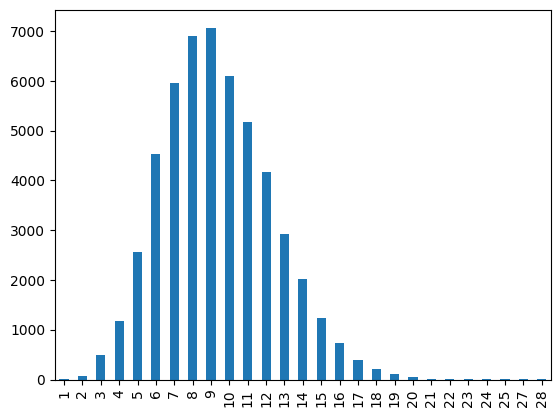

In [41]:
data_dev.word.apply(len).value_counts().sort_index().plot.bar()

<Axes: >

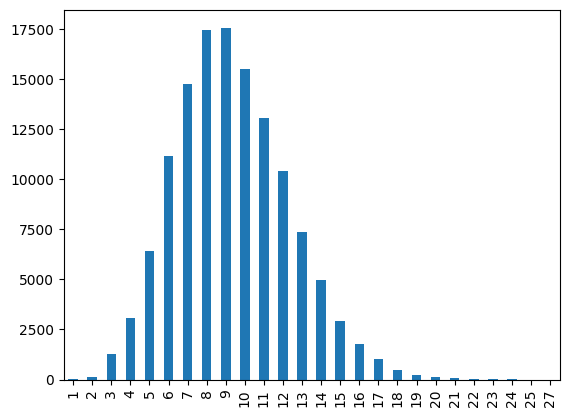

In [42]:
data_train.word.apply(len).value_counts().sort_index().plot.bar()

100%|██████████| 85/85 [00:05<00:00, 16.94it/s]


Epoch 1: Loss=2.493926763534546
Epoch 1: Training took: 7974.861067533493


100%|██████████| 51954/51954 [47:01<00:00, 18.42it/s]


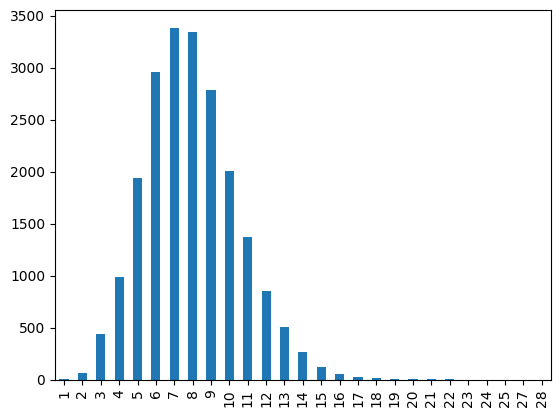

Epoch 1: Validation score improved to: 0.5487546675905609
Saving Down Model...
Epoch 1: Validating took: 2842.0017104148865


100%|██████████| 85/85 [00:04<00:00, 20.92it/s]


Epoch 2: Loss=5065.33056640625
Epoch 2: Training took: 6907.205796003342


100%|██████████| 51954/51954 [43:26<00:00, 19.94it/s]


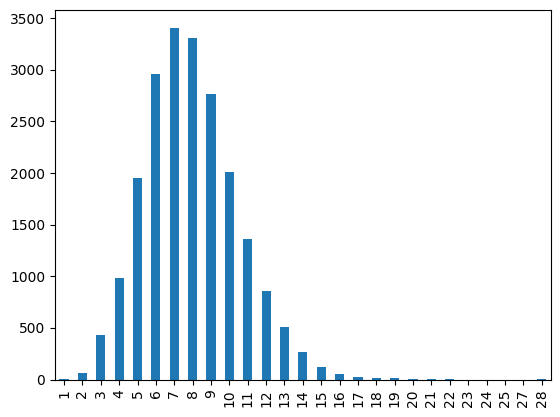

Epoch 2: Validation score did not improve: 0.5486199330176694
Setting new Learning Rate to: 0.000103680024
Epoch 2: Validating took: 2606.3900380134583


100%|██████████| 85/85 [00:04<00:00, 19.87it/s]


Epoch 3: Loss=5060.8017578125
Epoch 3: Training took: 6586.381969213486


100%|██████████| 51954/51954 [47:36<00:00, 18.19it/s]


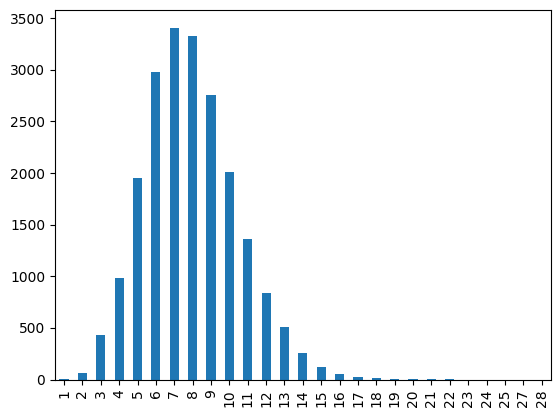

Epoch 3: Validation score did not improve: 0.5485044462409054
Setting new Learning Rate to: 6.220802e-05
Epoch 3: Validating took: 2856.3448781967163


100%|██████████| 85/85 [00:04<00:00, 17.43it/s]


Epoch 4: Loss=5060.015625
Epoch 4: Training took: 7393.5357031822205


100%|██████████| 51954/51954 [50:53<00:00, 17.01it/s]


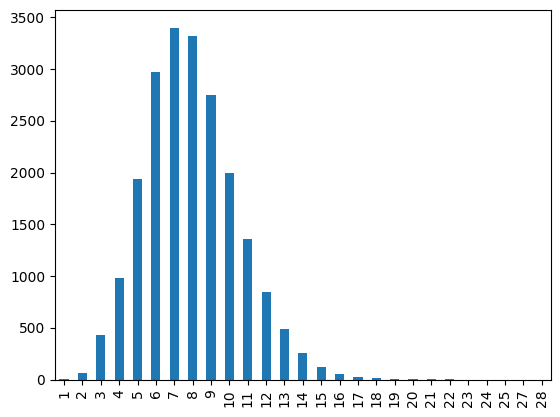

Epoch 4: Validation score improved to: 0.5500635177272203
Saving Down Model...
Epoch 4: Validating took: 3074.994786977768


100%|██████████| 85/85 [00:04<00:00, 18.95it/s]


Epoch 5: Loss=5045.2314453125
Epoch 5: Training took: 7077.634567975998


100%|██████████| 51954/51954 [48:41<00:00, 17.78it/s]


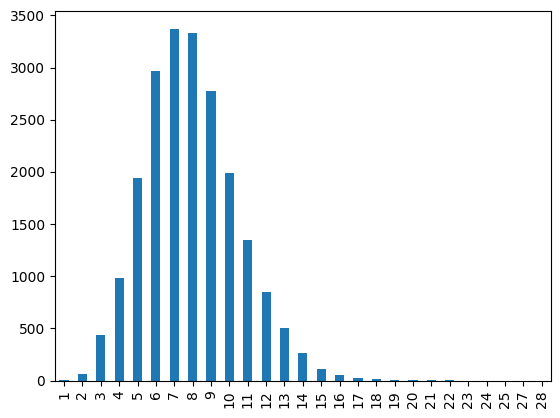

Epoch 5: Validation score did not improve: 0.5500635177272203
Setting new Learning Rate to: 3.732481e-05
Epoch 5: Validating took: 2921.8107872009277


100%|██████████| 85/85 [00:04<00:00, 18.06it/s]


Epoch 6: Loss=5044.19091796875
Epoch 6: Training took: 7716.040013551712


100%|██████████| 51954/51954 [47:23<00:00, 18.27it/s]


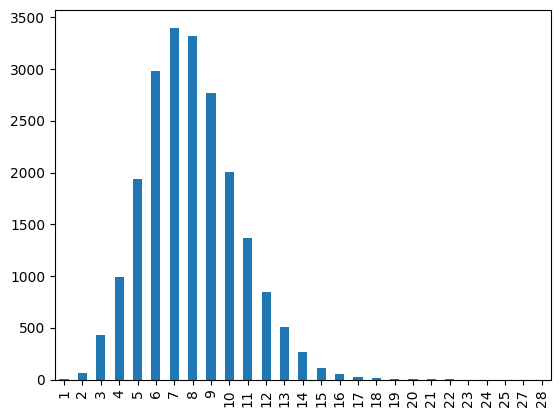

Epoch 6: Validation score did not improve: 0.5489663933479617
Setting new Learning Rate to: 2.2394888e-05
Epoch 6: Validating took: 2843.6173117160797


100%|██████████| 85/85 [00:04<00:00, 18.26it/s]


Epoch 7: Loss=5057.53564453125
Epoch 7: Training took: 7156.17490530014


100%|██████████| 51954/51954 [47:39<00:00, 18.17it/s]


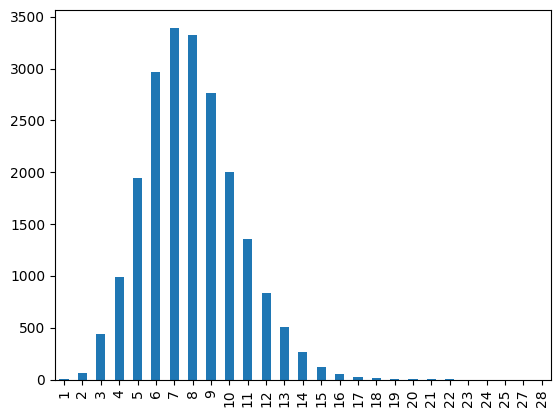

Epoch 7: Validation score did not improve: 0.5496400662124187
Setting new Learning Rate to: 1.3436934e-05
Epoch 7: Validating took: 2859.4951844215393


100%|██████████| 85/85 [00:04<00:00, 19.37it/s]


Epoch 8: Loss=5048.34130859375
Epoch 8: Training took: 7162.455074310303


100%|██████████| 51954/51954 [46:03<00:00, 18.80it/s]


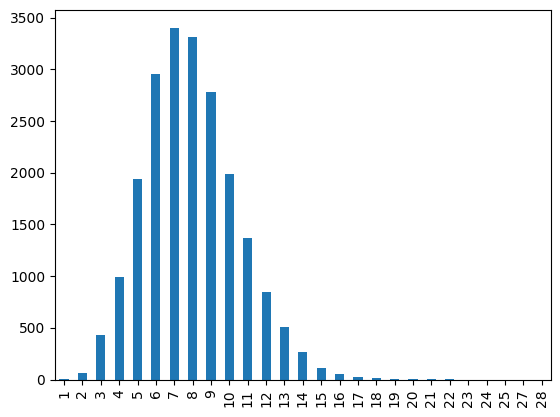

Epoch 8: Validation score did not improve: 0.5493513492705085
Setting new Learning Rate to: 8.06216e-06
Epoch 8: Validating took: 2764.020569562912


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Training loop
best_eval_score = 0.5481579859106133
count_scheduler = 0
words_per_batch = 100
NUM_EPOCHS = 100
weights_map = None

for epoch in range(NUM_EPOCHS):
    #Training
    s = time.time()
    epoch_words = list(np.random.permutation(data_train.word.values))
    reset_metrics = True
    word_idx = 0
    while word_idx < len(epoch_words):
        words_seen_, previous_letters_, stacked_ngrams_probs_, correct_responses_, lens_ = np.empty((0,MAX_NUM_INPUTS,27)), np.empty((0,26)),\
                                      np.empty((0,26,5)), np.empty((0,26)), []
        batch_words = epoch_words[word_idx:min(word_idx+words_per_batch, len(epoch_words))]
        word_idx += words_per_batch
        # Simulate Hangman game
        with tqdm(total=len(batch_words)) as pbar:
          with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
              futures = [executor.submit(simulate_hangman, word) for word in batch_words]
              for future in concurrent.futures.as_completed(futures):
                  words_seen, previous_letters, stacked_ngrams_probs, correct_responses, lens = future.result()
                  words_seen_, previous_letters_, stacked_ngrams_probs_, correct_responses_ = \
                      np.concatenate([words_seen_, words_seen], axis=0), np.concatenate([previous_letters_, previous_letters], axis=0),\
                        np.concatenate([stacked_ngrams_probs_, stacked_ngrams_probs], axis=0), np.concatenate([correct_responses_, correct_responses], axis=0)
                  lens_.append(lens)
                  pbar.update(1)
        if weights_map is None:
            # Train the model using the generated game data
            history = HANGMAN_MODEL.train_on_batch(
                x=[words_seen_, previous_letters_, stacked_ngrams_probs_],
                y=correct_responses_,
                sample_weight=None,
                class_weight=None,
                reset_metrics=reset_metrics,
                return_dict=True,
            )
        else:
            weights = []
            for i in lens_:
                for j in i:
                    weights.append(weights_map.get(j,0))
            # Train the model using the generated game data and weights
            history = HANGMAN_MODEL.train_on_batch(
                x=[words_seen_, previous_letters_, stacked_ngrams_probs_],
                y=correct_responses_,
                sample_weight=np.array(weights),
                class_weight=None,
                reset_metrics=reset_metrics,
                return_dict=True,
            )
        reset_metrics = False

    s1 = time.time()
    print(f"Epoch {epoch+1}: Loss={history['loss']}")
    print(f"Epoch {epoch+1}: Training took: {s1 - s}")

    #Validate
    n_successes = 0
    failures_map = {}
    lens_map = {}
    # Evaluate Hangman game
    with tqdm(total=len(data_dev)) as pbar:
      with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
          futures = [executor.submit(evaluate_hangman, word_) for word_ in data_dev.word.values]
          for future in concurrent.futures.as_completed(futures):
              is_success, len_ = future.result()
              lens_map[len_] = lens_map.get(len_, 0) + 1
              if is_success:
                  n_successes += 1
              else:
                  failures_map[len_] = failures_map.get(len_,0) + 1
              pbar.update(1)
    weights_map = {}
    for l_ in lens_map:
        weights_map[l_] = failures_map.get(l_,0)*(1-lens_map[l_]/len(data_dev))
    pd.Series(weights_map).sort_index().plot.bar()
    plt.show()
    eval_score = n_successes/len(data_dev)

    if eval_score > best_eval_score:
        best_eval_score = eval_score
        print(f"Epoch {epoch+1}: Validation score improved to: {best_eval_score}")
        print("Saving Down Model...")
        model_filename = '/content/drive/MyDrive/Trexquant/hangman_model_new_impr.dnn'
        HANGMAN_MODEL.save(model_filename)
    else:
        count_scheduler += 1
        print(f"Epoch {epoch+1}: Validation score did not improve: {eval_score}")
        if count_scheduler == 1:
            new_lr = HANGMAN_MODEL.optimizer.learning_rate*.6
            print("Setting new Learning Rate to:", new_lr.numpy())
            K.set_value(HANGMAN_MODEL.optimizer.learning_rate, new_lr)  # set new learning_rate
            count_scheduler = 0
    print(f"Epoch {epoch+1}: Validating took: {time.time() - s1}")

In [18]:
HANGMAN_MODEL = tf.keras.models.load_model('/content/drive/MyDrive/Trexquant/hangman_model_new_impr.dnn')

# Show the model architecture
HANGMAN_MODEL.summary()

Model: "hangman_rl_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_obscured_word_seen (  [(None, 29, 27)]             0         []                            
 InputLayer)                                                                                      
                                                                                                  
 masking (Masking)           (None, 29, 27)               0         ['input_obscured_word_seen[0][
                                                                    0]']                          
                                                                                                  
 bidirectional (Bidirection  (None, 29, 54)               11880     ['masking[0][0]']             
 al)                                                                               

In [22]:
n_successes = 0
failures_map = {}
lens_map = {}
# Evaluate Hangman game
with tqdm(total=len(data_test)) as pbar:
  with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
      futures = [executor.submit(evaluate_hangman, word_) for word_ in data_test.word.values]
      for future in concurrent.futures.as_completed(futures):
          is_success, len_ = future.result()
          lens_map[len_] = lens_map.get(len_, 0) + 1
          if is_success:
              n_successes += 1
          else:
              failures_map[len_] = failures_map.get(len_,0) + 1
          pbar.update(1)

100%|██████████| 45460/45460 [39:28<00:00, 19.20it/s]


In [23]:
n_successes/len(data_test) #Performance on Test Set

0.5508578970523537